<a href="https://colab.research.google.com/github/Sylvain-chateau/colab-small_projects/blob/master/Predicting_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
This notebook features a model for predicting house prices using the Boston_housing dataset. It is inspired by the book "Deep learning with Python" by Keras author François Chollet.

# 1. Loading & preparing the data

In [0]:
#Loading the Bonston_housing dataset, which is already preprocessed:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [11]:
#Explore the data
print("Training entries: {}, targets: {}".format(len(train_data), len(train_targets)))
print("Test entries: {}, targets: {}".format(len(test_data), len(test_targets)))

train_data.shape

Training entries: 404, targets: 404
Test entries: 102, targets: 102


(404, 13)

We have 404 training samples with 13 numerical features to help us predict the price of homes in a given Boston suburb in the mid-1970s. The targets are the median values of the house in thousands of dollars.

In [0]:
import numpy as np

#Normalizing the data:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# 2. Building the network

Because we don't have a lot of samples, we'll build a small network to mitigat overfitting

In [0]:
#model definition
from tensorflow.keras import models, layers

#Since we will use k-fold cross-validation, we will instantiate the model multiple times, thus we create a function for it.
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  #Compiling the model
  model.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['mae'])
  return model

## 2.1 K-fold cross validation

In [28]:
k = 5
num_val_samples = len(train_data) // k
num_epochs = 150
all_mae_histories = []

for i in range(k):
  print('processing fold #', i)
  #prepares the validation data from partition #k:
  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
  
  #prepares the training data:
  partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                       train_data[(i+1)*num_val_samples:]],
                                       axis=0)
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],
                                       train_targets[(i+1)*num_val_samples:]],
                                       axis=0)
  
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
                     validation_data=(val_data,val_targets),
                     epochs=num_epochs, batch_size=1, verbose=0)
  mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)
  
  

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [0]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## 2.2 Plotting the validation scores

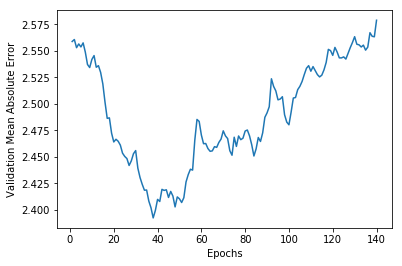

In [30]:
#Plotting the validation scores excluding the 10 first data points, and adding an exponential moving average on each point.
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])        

plt.plot(range(1, len(smooth_mae_history)+1 ), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Mean Absolute Error')
plt.show()

We start overfitting after 38 epochs.

## 2.3 Training the final model

In [31]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=38, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/sample - loss: 22.0878 - mean_absolute_error: 2.8620


We have an error of about 2860$ on the estimated price...